In [6]:
import glob

import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import metpy

from tqdm.notebook import tqdm

In [30]:
xr.set_options(keep_attrs=True)

In [2]:
dates = pd.date_range(start='2021-01-01', end='2022-01-01', freq='1d', inclusive="left", tz='GMT').values
files = {}
for i in dates:
    date = f'{pd.to_datetime(i).dayofyear:03}'
    files[date] = sorted(glob.glob(f'/Volumes/Shores/GOES/AODC/averages/2021/{date}/*.nc'))

In [13]:
with xr.open_dataset(files['001'][14]) as aod:
    aod.load()

In [41]:
geo = ccrs.Geostationary(
    central_longitude=aod.goes_imager_projection.longitude_of_projection_origin,
    satellite_height=aod.goes_imager_projection.perspective_point_height,
    sweep_axis=aod.goes_imager_projection.sweep_angle_axis
)

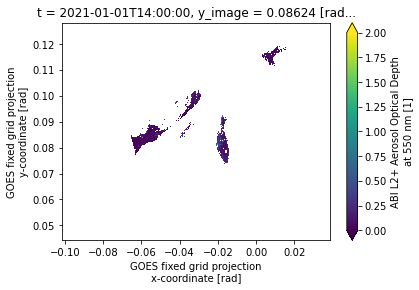

In [33]:
aod.isel(t=0)['AOD'].plot(vmin=0, vmax=2)

In [26]:
ds = xr.open_mfdataset(
    sorted(glob.glob('/Volumes/Shores/GOES/AODC/2021/001/14/*.nc')),
    concat_dim="t", 
    parallel=True, 
    combine='nested',
    data_vars='different', 
)

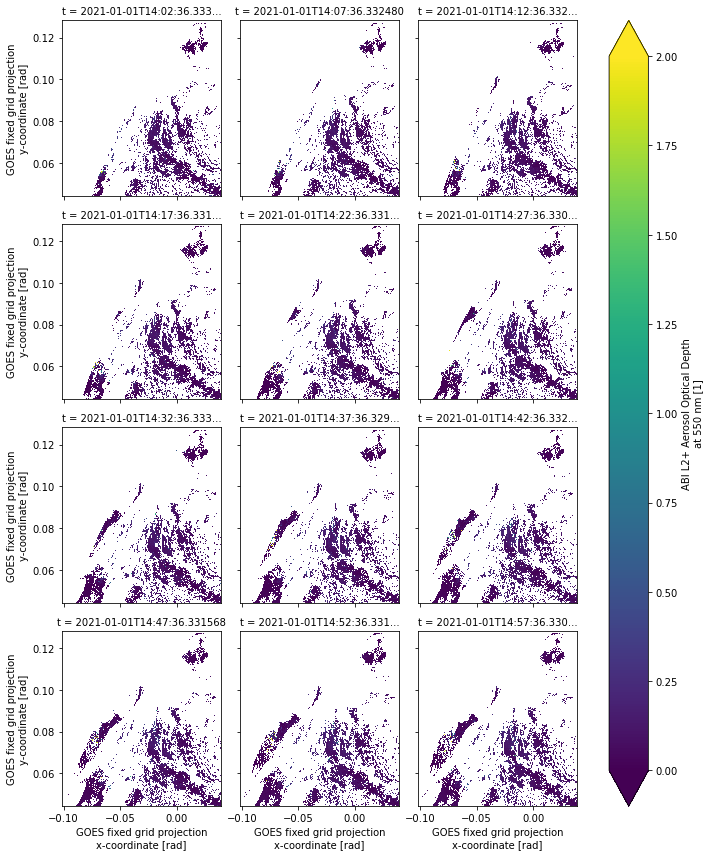

In [29]:
ds.where(ds.DQF < 2).AOD.plot(col='t', col_wrap=3, vmin=0, vmax=2)

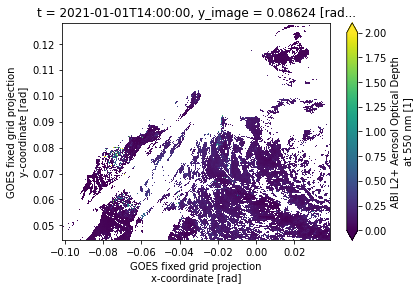

In [32]:
ds.where(ds.DQF < 2).resample(t='1h').mean().AOD.plot(vmin=0, vmax=2)

In [37]:
dat = aod.metpy.parse_cf('AOD')

In [46]:
dat.metpy.cartopy_crs

<Derived Projected CRS: +proj=geos +a=6378137.0 +b=6356752.31414 +rf=298.2 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Geostationary Satellite (Sweep X)
Datum: unknown
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [47]:
geo

<Derived Projected CRS: +proj=geos +ellps=WGS84 +lon_0=-75.0 +lat_0=0.0 +h ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Geostationary Satellite (Sweep X)
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [60]:
x = dat.x
y = dat.y

sat_h = aod.goes_imager_projection.perspective_point_height
x2 = aod.x * sat_h
y2 = aod.y * sat_h

pro = dat.metpy.cartopy_crs
aod.coords["x2"] = x2
aod.coords["y2"] = y2
aod["x2"].attrs["long_name"] = "x sweep in crs units (m); x * sat_height"
aod["y2"].attrs["long_name"] = "y sweep in crs units (m); y * sat_height"

X, Y = np.meshgrid(x2, y2)
a = ccrs.PlateCarree().transform_points(pro, X, Y)
lons, lats, _ = a[:, :, 0], a[:, :, 1], a[:, :, 2]

# ds = ds.assign_coords({
#         "lat":(["y","x"],lats),
#         "lon":(["y","x"],lons)
#     })
# ds.lat.attrs["units"] = "degrees_north"
# ds.lon.attrs["units"] = "degrees_east"
# return ds

In [63]:
lons.shape, lats.shape

((1500, 2500), (1500, 2500))

In [ ]:
aod.assign_coords(x=ds.x * sat_h, y=ds.y * sat_h)

In [74]:
lats

array([[        nan,         nan,         nan, ..., 51.36047934,
        51.36249181, 51.36450827],
       [        nan,         nan,         nan, ..., 51.32221062,
        51.32421725, 51.32622787],
       [        nan,         nan,         nan, ..., 51.28399392,
        51.28599476, 51.28799956],
       ...,
       [15.16044982, 15.15968922, 15.15892952, ..., 14.67643652,
        14.67663608, 14.67683596],
       [15.14051229, 15.13975293, 15.13899447, ..., 14.65725591,
        14.65745517, 14.65765474],
       [15.12057682, 15.1198187 , 15.11906148, ..., 14.63807676,
        14.63827571, 14.63847499]])

In [68]:
pro.to_proj4()

/usr/local/Caskroom/miniconda/base/envs/geospatial/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


'+proj=geos +a=6378137.0 +rf=298.2572221 +lon_0=-75.0 +lat_0=0.0 +h=35786023.0 +x_0=0 +y_0=0 +units=m +sweep=x +no_defs +type=crs'

In [71]:
from pyproj import Proj

In [73]:
p = Proj(pro.to_proj4())

/usr/local/Caskroom/miniconda/base/envs/geospatial/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [75]:
p(-52.98, 51.36)

(1379979.7007919708, 4588056.375920582)